In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import keras
import sys
import pandas as pd
import sklearn as sk
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print(tf.config.list_physical_devices("GPU"))
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.19.1
Keras Version: 3.12.0

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pandas 2.3.3
Scikit-Learn 1.7.2
[]
GPU is NOT AVAILABLE


In [2]:
# SEMILLA
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Parámetros
INPUT_FORMAT = (224, 224, 3)
BATCH_SIZE = 64  # trabajar con valores grandes - 16 si tiene poco recurso - aleatorio en cada epoca
EPOCHS = 150
INIT_LR = 1e-4  # se va reduciendo poco a poco o -3 o -2

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import os

path = "./Preprocessed Leaf_FILTERED"  # "/content/drive/MyDrive/Semestre/IA/Dataset/processed_dataset"
os.listdir(path)

['test', 'train', 'val']

In [6]:
# Cambia el import de vgg16 por este:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def tf_pytorch_style_preprocess(img):
    # Ahora sí reconocerá el argumento 'mode'
    return preprocess_input(img, mode='torch')
# Rutas
ruta_entrenamiento = f"{path}/train"
ruta_validacion = f"{path}/val"
ruta_test = f"{path}/test"


# Generadores
datagen = ImageDataGenerator(
    preprocessing_function=tf_pytorch_style_preprocess,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.20,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
)
datagen_valid = ImageDataGenerator(
    preprocessing_function=tf_pytorch_style_preprocess,
)  # ANTES APLIQUE RESCALE
datagen_test = ImageDataGenerator(
    preprocessing_function=tf_pytorch_style_preprocess,
)

generador_entrenamiento = datagen.flow_from_directory(
    ruta_entrenamiento,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
)

generador_validacion = datagen_valid.flow_from_directory(
    ruta_validacion,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

generador_test = datagen_test.flow_from_directory(
    ruta_test,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

Found 2750 images belonging to 4 classes.
Found 344 images belonging to 4 classes.
Found 346 images belonging to 4 classes.


In [7]:
# number of classes
num_classes = generador_entrenamiento.num_classes
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [8]:
steps = len(generador_entrenamiento.filepaths) // generador_entrenamiento.batch_size
steps

42

In [9]:
learning_rate = INIT_LR

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D


# Construccion del modelo
# --------------------------------------------------------------------------
def model_init(learning_rate, dropout_rate, l2_reg, is_transfer=True):
    if is_transfer:
        base_model = VGG16(
            weights="imagenet", include_top=False, input_shape=INPUT_FORMAT
        )
        for layer in base_model.layers:
            layer.trainable = False
    else:
        base_model = VGG16(weights=None, include_top=False, input_shape=INPUT_FORMAT)

    entrada = layers.Input(shape=INPUT_FORMAT)
    x = base_model(entrada)
    x = layers.Flatten()(x)
    x = layers.Dense(
        256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)
    )(
        x
    )  # revisar cuantas capas usa en esas 256 neuronas
    x = layers.Dropout(dropout_rate)(x)
    salida = layers.Dense(num_classes, activation="softmax")(x)  # Changed from 4 to 6

    model = Model(inputs=entrada, outputs=salida)
    optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizador, metrics=["accuracy"]
    )
    model.summary()
    return model

In [11]:
# Configuración de callbacks
import os

path_models = "./models/VGG16-with-transfer/"
os.makedirs(path_models, exist_ok=True)
arch = "VGG16"

## entrenamiento

In [ ]:
model = model_init(learning_rate, 0.6, 5e-3, is_transfer=True)
# si aumentas el valor de regularizador lo haces mas simple
# analizar:
# ver la arquitectura del modelo
# ver los hiperparametros, dropout revisar las graficas de despues del entrenamiento. max aumentar a 0.6

# que capas poner el dropout preguntar gpt

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
checkpoint = ModelCheckpoint(
    path_models + "model_vgg16.weights.h5",
    monitor="val_loss",  # <-- Guarda el mejor modelo basado en val_loss (más estable que val_accuracy)
    verbose=1,
    save_best_only=True,  # guarda cuando haya mejoras
    save_weights_only=True,
    mode="min",  # estaba en auto
)

early = EarlyStopping(
    monitor="val_loss",  # puede cambiar a value loss
    min_delta=0.001,
    patience=10,  # <-- Detén el entrenamiento cuando val_accuracy no mejore en 10 EPOCHS
    verbose=1,
    restore_best_weights=True,
    mode="min",
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitorear pérdida de validación
    mode="min",  # Reducir LR cuando val_loss deje de disminuir
    factor=0.5,  # Reducción moderada del LR
    patience=5,  # Esperar 5 EPOCHS sin mejora
    verbose=1,
    min_lr=1e-6,  # LR mínimo permitido+
)

# Añadir a los callbacks
callbacks = [checkpoint, reduce_lr, early]  # <-- Añadido

In [14]:
from sklearn.utils import class_weight
import numpy as np

# Calcular pesos para balancear las clases
train_labels = generador_entrenamiento.classes
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [15]:
historia_1 = model.fit(
    generador_entrenamiento,
    # steps_per_epoch=generador_entrenamiento.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generador_validacion,
    # validation_steps=generador_validacion.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,  # <-- Añadir esto
)

# ir viendo el validation acc: alto y el loss tiene que ser bajo

# disminuir el learning rate si hay muy bajo el acc o aumentar el dropout

Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5116 - loss: 3.6079
Epoch 1: val_loss improved from None to 2.57281, saving model to ./models/VGG16-with-transfer/model_vgg16.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.6196 - loss: 3.2410 - val_accuracy: 0.8110 - val_loss: 2.5728 - learning_rate: 1.0000e-04
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7741 - loss: 2.5907
Epoch 2: val_loss improved from 2.57281 to 2.18039, saving model to ./models/VGG16-with-transfer/model_vgg16.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.7767 - loss: 2.4967 - val_accuracy: 0.8605 - val_loss: 2.1804 - learning_rate: 1.0000e-04
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7890 - loss: 2.2340
Epoch 3: val_loss improved from 2.18039 to 1.99921, saving model to ./models/VGG16-with-transfer/model_vgg16.weights.h5
43/43 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step - accuracy: 0.7989 - loss: 2.1778 - val_accuracy: 0.8430 - val_

In [16]:
model.save(path_models + arch + "/model_vgg16.h5")

Learning rate actual: 3.12499992105586e-06


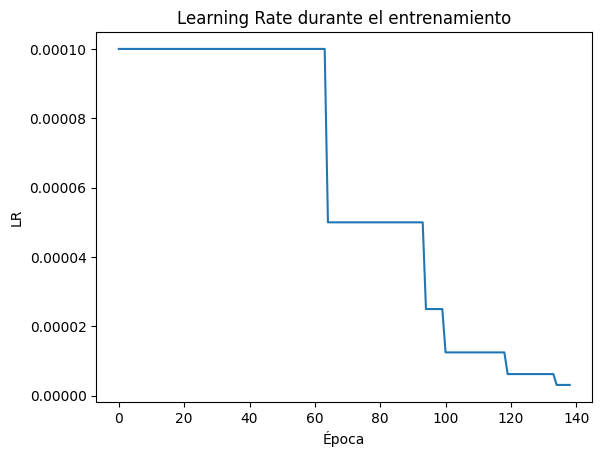

In [17]:
current_lr = model.optimizer.learning_rate.numpy()
print(f"Learning rate actual: {current_lr}")

# Graficar el learning rate a lo largo de las épocas
plt.plot(historia_1.history["learning_rate"])
plt.title("Learning Rate durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("LR")
plt.savefig(path_models + "VGG16_lr_plot.png")
plt.show()

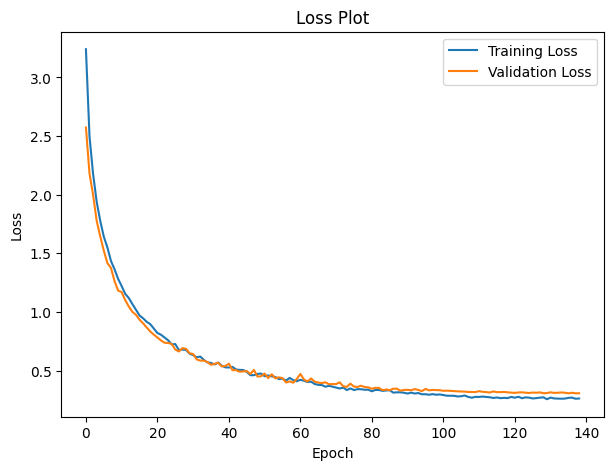

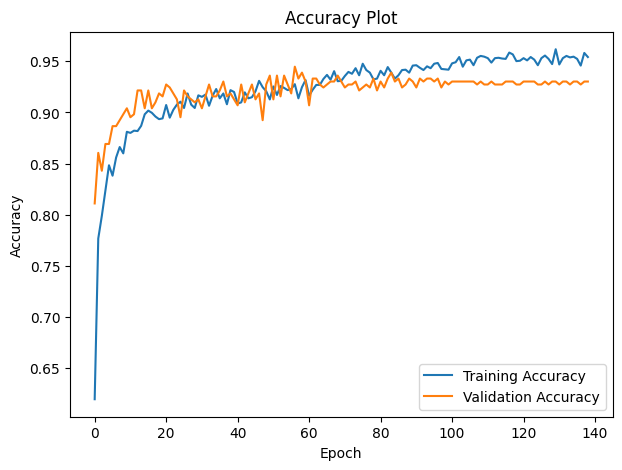

In [18]:
# Gráfico de Pérdida
plt.figure(figsize=(7, 5))
plt.plot(historia_1.history["loss"], label="Training Loss")
plt.plot(historia_1.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path_models + "VGG16_loss_plot.png")  # Guarda el gráfico en loss_plot.png
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(7, 5))
plt.plot(historia_1.history["accuracy"], label="Training Accuracy")
plt.plot(historia_1.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(
    path_models + "VGG16_accuracy_plot.png"
)  # Guarda el gráfico en accuracy_plot.png
plt.show()

In [28]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1. Definir la cantidad de muestras (imágenes)
total_samples = len(generador_test.classes)

# 2. Iniciar el cronómetro para el TIEMPO TOTAL
start_time = time.perf_counter()

# --- EJECUCIÓN DEL MODELO VGG16 ---
y_pred = model.predict(generador_test, verbose=1)
# ----------------------------------

# 3. Finalizar el cronómetro
end_time = time.perf_counter()

# 4. CÁLCULO DE TIEMPOS
total_inference_time = end_time - start_time  # Tiempo total en SEGUNDOS
avg_inference_time_ms = (total_inference_time / total_samples) * 1000  # Promedio en MILISEGUNDOS

# Procesar etiquetas para métricas
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# --- 1. CÁLCULO DE MÉTRICAS ---
accuracy = accuracy_score(true_labels, predicted_labels)

# Métricas por clase
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)
recall_per_class = recall_score(true_labels, predicted_labels, average=None, zero_division=0)
f1_per_class = f1_score(true_labels, predicted_labels, average=None, zero_division=0)

# Promedios Macro (Promedio simple de las clases)
avg_precision = np.mean(precision_per_class)
avg_recall = np.mean(recall_per_class)
avg_f1 = np.mean(f1_per_class)

# Eficiencia (Asegúrate de tener estas variables definidas tras tu loop de test)
# Si no las tienes, puedes comentar estas líneas:
avg_inference_time_ms = (total_inference_time / total_samples) * 1000

# --- 2. MATRIZ DE CONFUSIÓN VISUAL ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",  # 'd' para enteros, igual que en el reporte KAN
    cmap="Blues", # Cambiado de Pastel a Blues para consistencia
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predicción del Modelo", fontsize=12)
plt.ylabel("Realidad (Ground Truth)", fontsize=12)
plt.title(f"Matriz de Confusión VGG16 - Accuracy: {accuracy:.2%}", fontsize=14)

cm_path = os.path.join(path_models, "VGG16_confusion_matrix.png")
plt.tight_layout()
plt.savefig(cm_path)
plt.close()

# --- 3. TABLA DE MÉTRICAS EN PANDAS ---
metrics_df = pd.DataFrame(
    {
        "Clase": categories,
        "Precision": np.round(precision_per_class, 4),
        "Recall": np.round(recall_per_class, 4),
        "F1-Score": np.round(f1_per_class, 4),
    }
)

# --- 4. GENERACIÓN DEL REPORTE DE TEXTO (Formato profesional) ---
report_path = os.path.join(path_models, "VGG16_metrics_report.txt")

with open(report_path, "w", encoding="utf-8") as f:
    f.write("=" * 50 + "\n")
    f.write(f" REPORTE DE EVALUACIÓN VGG16: {time.strftime('%Y-%m-%d %H:%M')}\n")
    f.write("=" * 50 + "\n\n")

    f.write(f"Métricas Globales:\n")
    f.write(f"- Accuracy:          {accuracy:.4f} ({accuracy:.2%})\n")
    f.write(f"- Macro Precision:   {avg_precision:.4f}\n")
    f.write(f"- Macro Recall:      {avg_recall:.4f}\n")
    f.write(f"- Macro F1-Score:    {avg_f1:.4f}\n\n")

    f.write("-" * 30 + "\n")
    f.write("EFICIENCIA (Velocidad)\n")
    f.write("-" * 30 + "\n")
    f.write(f"- Muestras totales:  {total_samples}\n")
    f.write(f"- Tiempo total:      {total_inference_time:.4f} segundos\n")
    f.write(f"- Tiempo por imagen: {avg_inference_time_ms:.4f} ms\n\n")

    f.write("-" * 30 + "\n")
    f.write("DETALLE POR CLASE\n")
    f.write("-" * 30 + "\n")
    try:
        f.write(metrics_df.to_markdown(index=False))
    except:
        f.write(metrics_df.to_string(index=False))

    f.write("\n\n")
    f.write("Matriz de Confusión (Texto):\n")
    f.write(np.array2string(cm, separator=", "))

print(f"✅ Reporte y matriz de VGG16 guardados en: {path_models}")

✅ Reporte y matriz de VGG16 guardados en: ./models/VGG16-with-transfer/


In [ ]:
# import shutil
# import os

# source_folder = './models/VGG16'
# destination_drive_folder = '/content/drive/MyDrive/colab_models_backup/VGG16/changed_prepro'

# # Create the destination folder in Drive if it doesn't exist
# os.makedirs(destination_drive_folder, exist_ok=True)

# # Copy the entire 'models' folder to Google Drive
# try:
#     shutil.copytree(source_folder, destination_drive_folder, dirs_exist_ok=True)
#     print(f"Successfully copied '{source_folder}' to '{destination_drive_folder}'")
# except Exception as e:
#     print(f"Error copying folder: {e}")